In [1]:
import torch
import torch.nn as nn             #muntar xarxes (capes, activacions, backpropagació de gradients...)
import torch.optim as optim       #escollir optimitzador que recalcularà els pesos
import torch.nn.functional as F   #cridar directament a funcions sense acudir a les classes
import torch.utils.data as data   #muntar dataloaders que generaran els batches de dades

import torchvision                #eines diverses per descarregar bases de dades, transformar dades...

import matplotlib.pyplot as plt   #mostrar, plotejar, displayar dades i imatges

In [2]:
# hiperparàmetres
batch_size =    100                 #per simplificar farem servir mateixa mida per training i test 
learning_rate = 0.01                #tasa d'aprenentatge
momentum =      0.1                  #paràmetre pel cas de l'optimitzador SGD (Stochastic gradient descent)
n_epochs =      10                  #vegades que la xarxa veurà totes les dades d'entrenament
criterium = nn.CrossEntropyLoss() #loss function 

torch.Size([1, 28, 28])


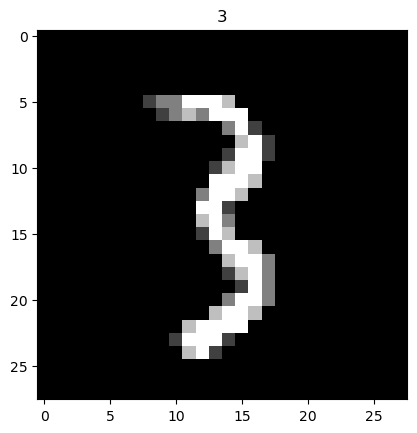

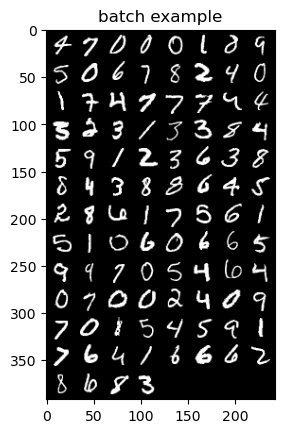

tensor([4, 7, 0, 0, 0, 1, 8, 9, 5, 0, 6, 7, 8, 2, 4, 0, 1, 7, 4, 7, 7, 7, 4, 4,
        3, 2, 3, 1, 3, 3, 8, 4, 5, 9, 1, 2, 3, 6, 3, 8, 8, 4, 3, 8, 8, 6, 4, 5,
        2, 8, 6, 1, 7, 5, 6, 1, 5, 1, 0, 6, 0, 6, 6, 5, 9, 9, 7, 0, 5, 4, 6, 4,
        0, 7, 0, 0, 2, 4, 0, 9, 7, 0, 1, 5, 4, 5, 9, 1, 7, 6, 4, 1, 6, 6, 6, 2,
        8, 6, 8, 3])


In [3]:
# dades 
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])   

train_data = torchvision.datasets.MNIST('/files/', train=True,  download=True, transform=trans)
test_data  = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=trans) 


train_loader = data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
test_loader =  data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# exemple de mostra
idx = 13488                       #un qualsevol per veure com són
input_example,target_example = train_data.__getitem__(idx)
print(input_example.size())       #mida de cada mostra/imatge/digit
plt.imshow(input_example[0,:,:], cmap='gray')
plt.title(str(target_example))
plt.show()

# exemple de batch
dataiter = iter(train_loader)
batch_images_example, batch_labels_example = next(dataiter)

plt.imshow(torchvision.utils.make_grid(batch_images_example)[0,:,:], cmap='gray')
plt.title('batch example')
plt.show()
print(batch_labels_example)

In [4]:
# definició de la xarxa
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,40,5)   #def convolutonal layer 
        self.conv2 = nn.Conv2d(40,60,5)  #def convolutonal layer 
        self.fc1 = nn.Linear(60*4*4,50)  #def fully connected layer
        self.fc2 = nn.Linear(50,10)      #def fully connected layer

    def forward(self, x):         #size [100,1,28,28] [batch,channels,height,width]
        x = F.relu(self.conv1(x)) #size [100,1,24,24] padding effect
        x = F.max_pool2d(x,2)     #size [100,1,12,12] downsampling      
        x = F.relu(self.conv2(x)) #size [100,1,8,8]   padding effect
        x = F.max_pool2d(x,2)     #size [100,1,4,4]   downsampling      
        x = torch.flatten(x,1)    #flatten all dimensions except batch
        x = F.relu(self.fc1(x))   #size [100,320] 
        x = self.fc2(x)           #size [100,50]  
        return x                  #size [100,10]  

In [5]:
# instanciació de la xarxa i l'optimitzador
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [6]:
# variables per graficar resultats
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [7]:
# definició dels bucles d'aprenentatge i test (validació)
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = criterium(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:      #mostra log cada 100 batches
      print('epoch: {:2d} [{:5d}/{} ({:3.0f}%)]\tloss: {:.6f}'.format(
        epoch+1, batch_idx*len(data), len(train_loader.dataset),
        100.0*batch_idx/len(train_loader), loss.item()/batch_size))
      train_losses.append(loss.item()/batch_size)
      train_counter.append(batch_idx*batch_size+epoch*len(train_loader.dataset))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += criterium(output, target)
      _,pred = torch.max(output.data,1)   
      correct += (pred == target).sum().item() 
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss.item())
  print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:5.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))    
  return correct  

In [8]:
# llencem els experiments
test()
for epoch in range(n_epochs):
  train(epoch)
  correct = test()


Test set: Avg. loss: 0.023072, Accuracy: 980/10000 ( 9.80%)

epoch:  1 [    0/60000 (  0%)]	loss: 0.023038
epoch:  1 [10000/60000 ( 17%)]	loss: 0.022666
epoch:  1 [20000/60000 ( 33%)]	loss: 0.021328
epoch:  1 [30000/60000 ( 50%)]	loss: 0.014115
epoch:  1 [40000/60000 ( 67%)]	loss: 0.006948
epoch:  1 [50000/60000 ( 83%)]	loss: 0.005820

Test set: Avg. loss: 0.003821, Accuracy: 8919/10000 (89.19%)

epoch:  2 [    0/60000 (  0%)]	loss: 0.003991
epoch:  2 [10000/60000 ( 17%)]	loss: 0.003312
epoch:  2 [20000/60000 ( 33%)]	loss: 0.002953
epoch:  2 [30000/60000 ( 50%)]	loss: 0.002371
epoch:  2 [40000/60000 ( 67%)]	loss: 0.002367
epoch:  2 [50000/60000 ( 83%)]	loss: 0.002673

Test set: Avg. loss: 0.002191, Accuracy: 9364/10000 (93.64%)

epoch:  3 [    0/60000 (  0%)]	loss: 0.002276
epoch:  3 [10000/60000 ( 17%)]	loss: 0.003586
epoch:  3 [20000/60000 ( 33%)]	loss: 0.001950
epoch:  3 [30000/60000 ( 50%)]	loss: 0.002290
epoch:  3 [40000/60000 ( 67%)]	loss: 0.001506
epoch:  3 [50000/60000 ( 83%)]


Test set: Avg. loss: 0.000682, Accuracy: 9793/10000 ( 98%)



<function matplotlib.pyplot.show(close=None, block=None)>

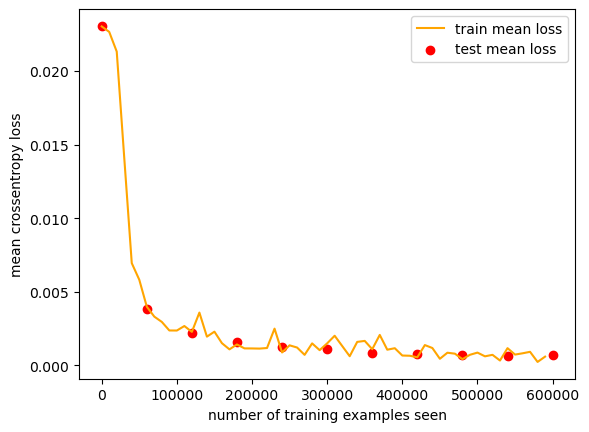

In [9]:
# mostrem els resultats
print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:3.0f}%)\n'.format(
    test_losses[-1], correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))     

fig = plt.figure()
plt.plot(train_counter, train_losses, color='orange')

plt.scatter(test_counter, test_losses, color='red')
plt.legend(['train mean loss', 'test mean loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('mean crossentropy loss')
plt.show

# SEGONS HIPERPARÀMETRES

In [10]:
# hiperparàmetres
batch_size =    200                 #per simplificar farem servir mateixa mida per training i test 
learning_rate = 0.1                #tasa d'aprenentatge
momentum =      0.15                  #paràmetre pel cas de l'optimitzador SGD (Stochastic gradient descent)
n_epochs =      12                  #vegades que la xarxa veurà totes les dades d'entrenament
criterium = nn.CrossEntropyLoss() #loss function 

torch.Size([1, 28, 28])


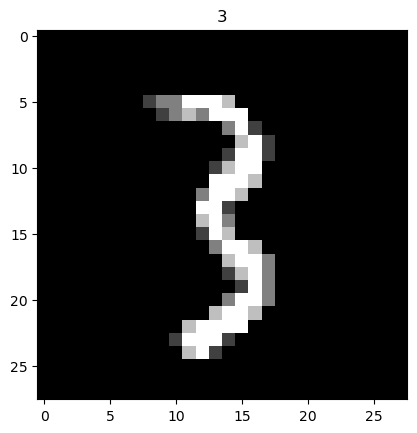

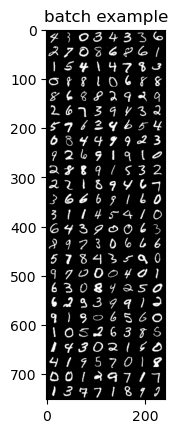

tensor([4, 3, 0, 3, 4, 3, 3, 6, 2, 7, 0, 8, 6, 8, 6, 1, 1, 5, 4, 1, 4, 7, 8, 3,
        0, 8, 8, 1, 0, 6, 8, 8, 8, 6, 8, 8, 2, 9, 2, 9, 2, 6, 7, 3, 9, 4, 3, 2,
        5, 7, 6, 3, 4, 6, 5, 4, 0, 8, 4, 4, 9, 9, 2, 3, 9, 2, 6, 9, 1, 9, 1, 0,
        2, 8, 8, 9, 1, 5, 3, 2, 2, 2, 1, 8, 9, 4, 6, 7, 3, 6, 6, 6, 9, 1, 6, 0,
        3, 1, 1, 4, 5, 4, 1, 0, 6, 4, 3, 9, 0, 0, 6, 3, 8, 9, 7, 3, 0, 6, 6, 6,
        5, 7, 8, 4, 3, 5, 9, 0, 9, 7, 0, 0, 0, 4, 0, 1, 6, 3, 0, 8, 4, 2, 5, 0,
        6, 2, 9, 3, 9, 9, 1, 2, 9, 1, 9, 0, 6, 5, 6, 0, 1, 0, 5, 2, 6, 3, 8, 5,
        1, 4, 3, 0, 2, 1, 5, 0, 4, 1, 9, 5, 7, 0, 1, 8, 0, 0, 1, 2, 9, 7, 1, 7,
        1, 3, 7, 7, 1, 8, 9, 2])


In [11]:
# dades 
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])   

train_data = torchvision.datasets.MNIST('/files/', train=True,  download=True, transform=trans)
test_data  = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=trans) 


train_loader = data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
test_loader =  data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# exemple de mostra
idx = 13488                       #un qualsevol per veure com són
input_example,target_example = train_data.__getitem__(idx)
print(input_example.size())       #mida de cada mostra/imatge/digit
plt.imshow(input_example[0,:,:], cmap='gray')
plt.title(str(target_example))
plt.show()

# exemple de batch
dataiter = iter(train_loader)
batch_images_example, batch_labels_example = next(dataiter)

plt.imshow(torchvision.utils.make_grid(batch_images_example)[0,:,:], cmap='gray')
plt.title('batch example')
plt.show()
print(batch_labels_example)

In [12]:
# instanciació de la xarxa i l'optimitzador
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [13]:
# variables per graficar resultats
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [14]:
# llencem els experiments
test()
for epoch in range(n_epochs):
  train(epoch)
  correct = test()


Test set: Avg. loss: 0.011529, Accuracy: 497/10000 ( 4.97%)

epoch:  1 [    0/60000 (  0%)]	loss: 0.011523
epoch:  1 [20000/60000 ( 33%)]	loss: 0.001350
epoch:  1 [40000/60000 ( 67%)]	loss: 0.000784

Test set: Avg. loss: 0.000551, Accuracy: 9657/10000 (96.57%)

epoch:  2 [    0/60000 (  0%)]	loss: 0.000475
epoch:  2 [20000/60000 ( 33%)]	loss: 0.000518
epoch:  2 [40000/60000 ( 67%)]	loss: 0.000531

Test set: Avg. loss: 0.000382, Accuracy: 9771/10000 (97.71%)

epoch:  3 [    0/60000 (  0%)]	loss: 0.000374
epoch:  3 [20000/60000 ( 33%)]	loss: 0.000189
epoch:  3 [40000/60000 ( 67%)]	loss: 0.000472

Test set: Avg. loss: 0.000308, Accuracy: 9798/10000 (97.98%)

epoch:  4 [    0/60000 (  0%)]	loss: 0.000230
epoch:  4 [20000/60000 ( 33%)]	loss: 0.000232
epoch:  4 [40000/60000 ( 67%)]	loss: 0.000300

Test set: Avg. loss: 0.000290, Accuracy: 9825/10000 (98.25%)

epoch:  5 [    0/60000 (  0%)]	loss: 0.000677
epoch:  5 [20000/60000 ( 33%)]	loss: 0.000216
epoch:  5 [40000/60000 ( 67%)]	loss: 0.000


Test set: Avg. loss: 0.000141, Accuracy: 9895/10000 ( 99%)



<function matplotlib.pyplot.show(close=None, block=None)>

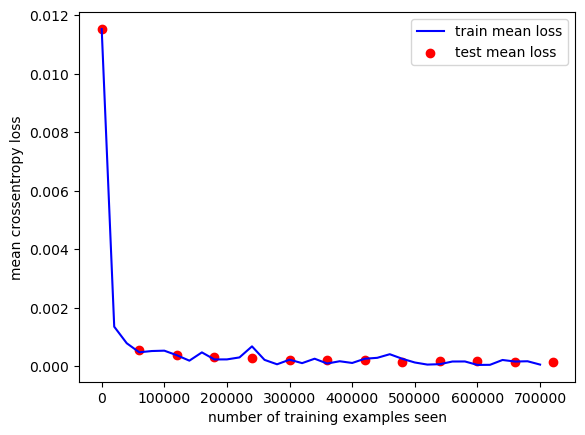

In [15]:
# mostrem els resultats
print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:3.0f}%)\n'.format(
    test_losses[-1], correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))     

fig2 = plt.figure()
plt.plot(train_counter, train_losses, color='blue')

plt.scatter(test_counter, test_losses, color='red')
plt.legend(['train mean loss', 'test mean loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('mean crossentropy loss')
plt.show

# TERCERS HIPERPARÀMETRES

In [16]:
# hiperparàmetres
batch_size =    50                 #per simplificar farem servir mateixa mida per training i test 
learning_rate = 0.05                #tasa d'aprenentatge
momentum =      0.05                  #paràmetre pel cas de l'optimitzador SGD (Stochastic gradient descent)
n_epochs =      7                  #vegades que la xarxa veurà totes les dades d'entrenament
criterium = nn.CrossEntropyLoss() #loss function 

torch.Size([1, 28, 28])


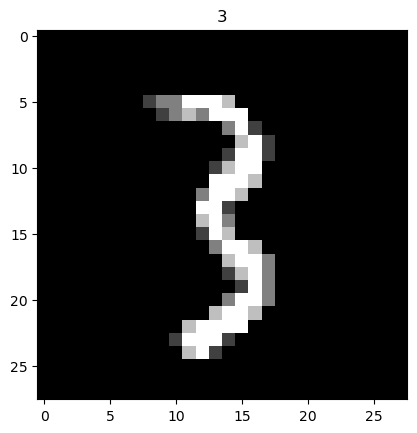

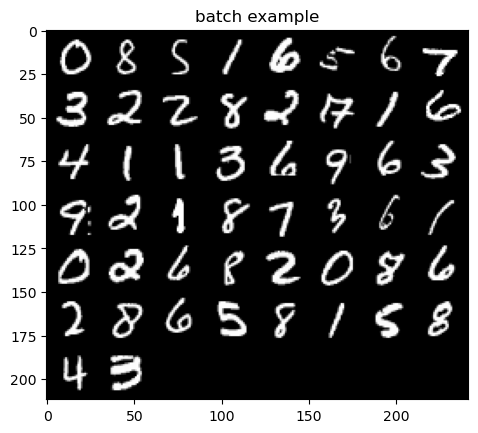

tensor([0, 8, 5, 1, 6, 5, 6, 7, 3, 2, 2, 8, 2, 7, 1, 6, 4, 1, 1, 3, 6, 9, 6, 3,
        9, 2, 1, 8, 7, 3, 6, 1, 0, 2, 6, 8, 2, 0, 8, 6, 2, 8, 6, 5, 8, 1, 5, 8,
        4, 3])


In [17]:
# dades 
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])   

train_data = torchvision.datasets.MNIST('/files/', train=True,  download=True, transform=trans)
test_data  = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=trans) 


train_loader = data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
test_loader =  data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# exemple de mostra
idx = 13488                       #un qualsevol per veure com són
input_example,target_example = train_data.__getitem__(idx)
print(input_example.size())       #mida de cada mostra/imatge/digit
plt.imshow(input_example[0,:,:], cmap='gray')
plt.title(str(target_example))
plt.show()

# exemple de batch
dataiter = iter(train_loader)
batch_images_example, batch_labels_example = next(dataiter)

plt.imshow(torchvision.utils.make_grid(batch_images_example)[0,:,:], cmap='gray')
plt.title('batch example')
plt.show()
print(batch_labels_example)

In [18]:
# instanciació de la xarxa i l'optimitzador
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [19]:
# variables per graficar resultats
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [20]:
# llencem els experiments
test()
for epoch in range(n_epochs):
  train(epoch)
  correct = test()


Test set: Avg. loss: 0.046027, Accuracy: 1865/10000 (18.65%)

epoch:  1 [    0/60000 (  0%)]	loss: 0.045961
epoch:  1 [ 5000/60000 (  8%)]	loss: 0.016063
epoch:  1 [10000/60000 ( 17%)]	loss: 0.006594
epoch:  1 [15000/60000 ( 25%)]	loss: 0.005418
epoch:  1 [20000/60000 ( 33%)]	loss: 0.003629
epoch:  1 [25000/60000 ( 42%)]	loss: 0.006132
epoch:  1 [30000/60000 ( 50%)]	loss: 0.003274
epoch:  1 [35000/60000 ( 58%)]	loss: 0.002349
epoch:  1 [40000/60000 ( 67%)]	loss: 0.003800
epoch:  1 [45000/60000 ( 75%)]	loss: 0.001619
epoch:  1 [50000/60000 ( 83%)]	loss: 0.002412
epoch:  1 [55000/60000 ( 92%)]	loss: 0.000853

Test set: Avg. loss: 0.002042, Accuracy: 9700/10000 (97.00%)

epoch:  2 [    0/60000 (  0%)]	loss: 0.003432
epoch:  2 [ 5000/60000 (  8%)]	loss: 0.001921
epoch:  2 [10000/60000 ( 17%)]	loss: 0.000582
epoch:  2 [15000/60000 ( 25%)]	loss: 0.000888
epoch:  2 [20000/60000 ( 33%)]	loss: 0.000899
epoch:  2 [25000/60000 ( 42%)]	loss: 0.002094
epoch:  2 [30000/60000 ( 50%)]	loss: 0.001152



Test set: Avg. loss: 0.000617, Accuracy: 9903/10000 ( 99%)



<function matplotlib.pyplot.show(close=None, block=None)>

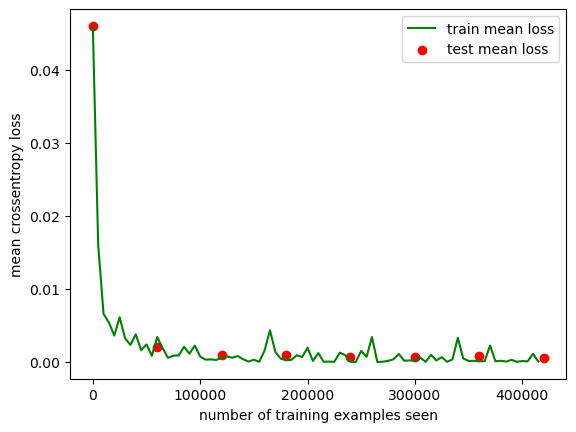

In [21]:
# mostrem els resultats
print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:3.0f}%)\n'.format(
    test_losses[-1], correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))     

fig3 = plt.figure()
plt.plot(train_counter, train_losses, color='green')

plt.scatter(test_counter, test_losses, color='red')
plt.legend(['train mean loss', 'test mean loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('mean crossentropy loss')
plt.show

# QUARTS HIPERPARÀMETRES

In [22]:
# hiperparàmetres
batch_size =    25                 #per simplificar farem servir mateixa mida per training i test 
learning_rate = 0.07                #tasa d'aprenentatge
momentum =      0.25                  #paràmetre pel cas de l'optimitzador SGD (Stochastic gradient descent)
n_epochs =      5                  #vegades que la xarxa veurà totes les dades d'entrenament
criterium = nn.CrossEntropyLoss() #loss function 

torch.Size([1, 28, 28])


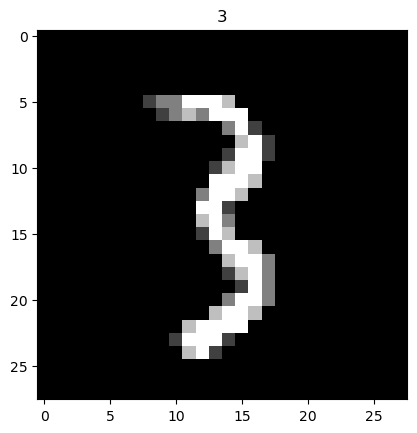

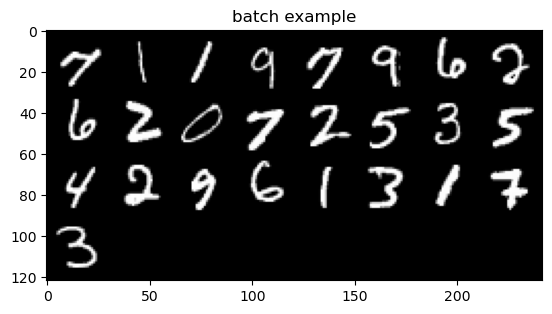

tensor([7, 1, 1, 9, 7, 9, 6, 2, 6, 2, 0, 7, 2, 5, 3, 5, 4, 2, 9, 6, 1, 3, 1, 7,
        3])


In [23]:
# dades 
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])   

train_data = torchvision.datasets.MNIST('/files/', train=True,  download=True, transform=trans)
test_data  = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=trans) 


train_loader = data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
test_loader =  data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# exemple de mostra
idx = 13488                       #un qualsevol per veure com són
input_example,target_example = train_data.__getitem__(idx)
print(input_example.size())       #mida de cada mostra/imatge/digit
plt.imshow(input_example[0,:,:], cmap='gray')
plt.title(str(target_example))
plt.show()

# exemple de batch
dataiter = iter(train_loader)
batch_images_example, batch_labels_example = next(dataiter)

plt.imshow(torchvision.utils.make_grid(batch_images_example)[0,:,:], cmap='gray')
plt.title('batch example')
plt.show()
print(batch_labels_example)

In [24]:
# instanciació de la xarxa i l'optimitzador
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [25]:
# variables per graficar resultats
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [26]:
# llencem els experiments
test()
for epoch in range(n_epochs):
  train(epoch)
  correct = test()


Test set: Avg. loss: 0.092060, Accuracy: 1004/10000 (10.04%)

epoch:  1 [    0/60000 (  0%)]	loss: 0.093452
epoch:  1 [ 2500/60000 (  4%)]	loss: 0.021879
epoch:  1 [ 5000/60000 (  8%)]	loss: 0.014749
epoch:  1 [ 7500/60000 ( 12%)]	loss: 0.006293
epoch:  1 [10000/60000 ( 17%)]	loss: 0.004583
epoch:  1 [12500/60000 ( 21%)]	loss: 0.005721
epoch:  1 [15000/60000 ( 25%)]	loss: 0.005395
epoch:  1 [17500/60000 ( 29%)]	loss: 0.000187
epoch:  1 [20000/60000 ( 33%)]	loss: 0.010254
epoch:  1 [22500/60000 ( 38%)]	loss: 0.003339
epoch:  1 [25000/60000 ( 42%)]	loss: 0.004087
epoch:  1 [27500/60000 ( 46%)]	loss: 0.003261
epoch:  1 [30000/60000 ( 50%)]	loss: 0.000146
epoch:  1 [32500/60000 ( 54%)]	loss: 0.001968
epoch:  1 [35000/60000 ( 58%)]	loss: 0.008501
epoch:  1 [37500/60000 ( 62%)]	loss: 0.001592
epoch:  1 [40000/60000 ( 67%)]	loss: 0.002238
epoch:  1 [42500/60000 ( 71%)]	loss: 0.007916
epoch:  1 [45000/60000 ( 75%)]	loss: 0.004095
epoch:  1 [47500/60000 ( 79%)]	loss: 0.008436
epoch:  1 [50000/


Test set: Avg. loss: 0.001128, Accuracy: 9908/10000 ( 99%)



<function matplotlib.pyplot.show(close=None, block=None)>

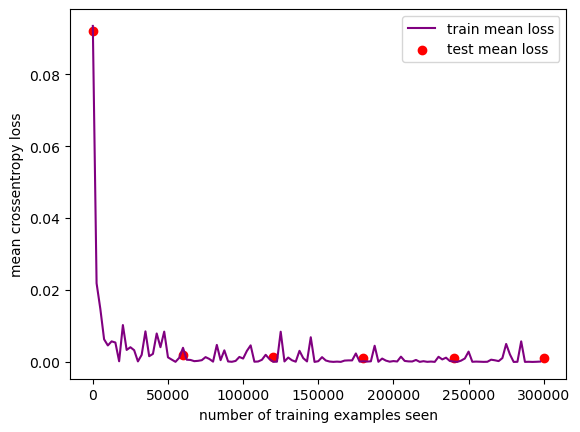

In [27]:
# mostrem els resultats
print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:3.0f}%)\n'.format(
    test_losses[-1], correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))     

fig4 = plt.figure()
plt.plot(train_counter, train_losses, color='purple')

plt.scatter(test_counter, test_losses, color='red')
plt.legend(['train mean loss', 'test mean loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('mean crossentropy loss')
plt.show